<center>
    <img src="https://github.com/GuitarsAI/ADSP_Tutorials/blob/master/images/adsp_logo.png?raw=1">
</center>

### Prof. Dr. -Ing. Gerald Schuller <br> Jupyter Notebook: Renato Profeta


# Frequency Warping and Minimum Phase Filters

In [25]:
%%html
<iframe width="560" height="315" src="https://www.youtube.com/embed/-kmD8XO4H8M" frameborder="0" allow="accelerometer;
encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

**Example:** Design a warped low pass filter with cutoff frequency of $0.05 \cdot \pi$ ($\pi$ is the Nyquist frequency). Observe: here this
frequency is the end of passband, with frequency warping close to the Bark scale of human hearing.

First as a comparison: design an unwarped filter with 4 coefficients/taps with these specifications:

In [26]:
%%html
<iframe width="560" height="315" src="https://www.youtube.com/embed/abEz2p1yDIU" frameborder="0" allow="accelerometer; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

cunw (Remez Unwarped) [0.0039992  0.00381763 0.00549593 0.00753716 0.00994719 0.01270979
 0.01580454 0.01920338 0.02284072 0.02665818 0.03056724 0.03448388
 0.03830789 0.04193939 0.0452792  0.04822907 0.05070566 0.05263109
 0.05395001 0.05461924 0.05461924 0.05395001 0.05263109 0.05070566
 0.04822907 0.0452792  0.04193939 0.03830789 0.03448388 0.03056724
 0.02665818 0.02284072 0.01920338 0.01580454 0.01270979 0.00994719
 0.00753716 0.00549593 0.00381763 0.0039992 ]


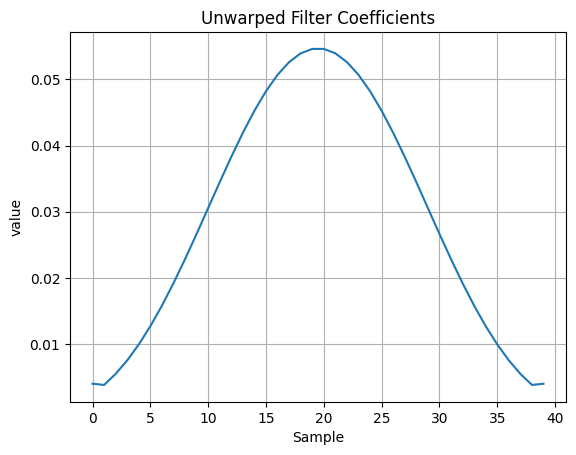

In [27]:
# Imports
import scipy.signal as sp
import matplotlib.pyplot as plt

#remez is normalizing to sampling frequency=1!
cunw = sp.remez(40,[0, 0.025, 0.025+0.025, 0.5],[1,0],[1, 100])
print('cunw (Remez Unwarped)', cunw)

#impulse response:
plt.figure()
plt.plot(cunw)
plt.xlabel('Sample'),
plt.ylabel('value')
plt.title('Unwarped Filter Coefficients')
plt.grid()

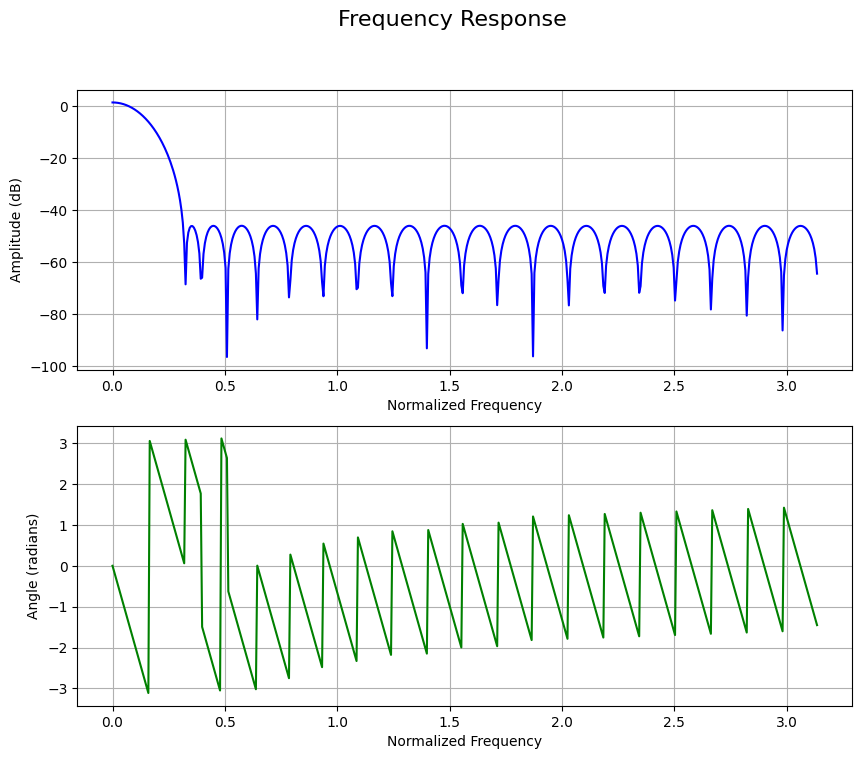

In [28]:
from scipy.signal import freqz
import numpy as np

w, h_response  = freqz(cunw)

fig=plt.figure(figsize=(10,8))
fig.suptitle('Frequency Response', fontsize=16)
plt.subplot(2,1,1)
plt.plot(w, 20 * np.log10(abs(h_response)), 'b')
plt.ylabel('Amplitude (dB)')
plt.xlabel('Normalized Frequency')
plt.grid()
plt.subplot(2,1,2)
angles = np.angle(h_response)
plt.plot(w, angles, 'g')
plt.ylabel('Angle (radians)')
plt.xlabel('Normalized Frequency')
plt.grid()

Here we can see that this is not a good filter.

The passband is too wide (up to about 0.15), and there is almost no stopband attenuation (in the range of 0.5 to 0.9). So this filter is probably **useless** for our application.

Now design the FIR low pass filter (4th order), which we then want to frequency warp in the next step, with a warped cutoff frequency.

First we have to compute the allpass coefficient „a“ for our allpass filter which results in an approximate Bark warping, according to [1]: https://ccrma.stanford.edu/~jos/bbt/bbt.pdf, equation 26.

$$\large
a=1.0674 \cdot \left( \dfrac{2}{\pi} \cdot \arctan{ \left( 0.06583 \cdot f_s \right)} \right)^{0.5} {-0.1916} $$
with $f_s$, the sampling frequency in kHz. Our warped design is then:

In [29]:
%%html
<iframe src='https://ieeexplore.ieee.org/document/799695', width=1000, height=500></iframe>

a: 0.7127618095184708
fcw: 0.8775541998493622
fcny: 0.139667088737079


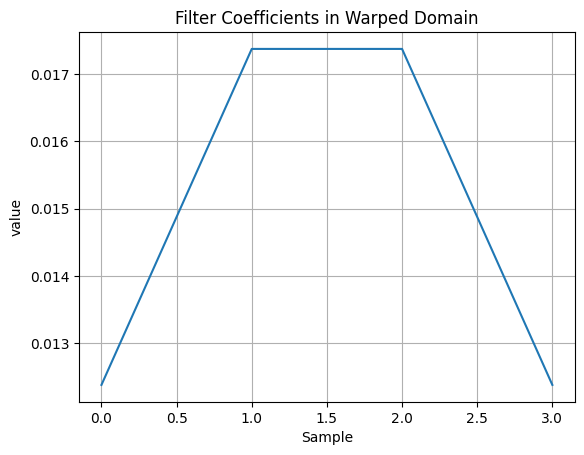

In [30]:
import numpy as np
def warpingphase(w, a):
    #produces (outputs) phase wy for an allpass filter
    #w: input vector of normlized frequencies (0..pi)
    #a: allpass coefficient
    #phase of allpass zero/pole :
    theta = np.angle(a);
    #magnitude of allpass zero/pole :
    r = np.abs(a);
    wy = - w - 2 * np.arctan((r*np.sin(w - theta))/(1 - r*np.cos(w - theta)))
    return wy

#warping allpass coefficient:
a = 1.0674*(2/np.pi*np.arctan(0.06583*32))**0.5 - 0.1916
print('a:',a)
# with f_s=32 in kHz. from [1]
# The warped cutoff frequency then is:
fcw=-warpingphase(0.05*np.pi, a)
print('fcw:',fcw)
# filter design:
# cutoff frequency normalized to 2 pi for remez:
fcny=fcw/(2*np.pi)
print('fcny:',fcny)

c = sp.remez(4, [0, fcny, fcny+0.1, 0.5],[1, 0],[1, 100]);
#The resulting Impulse Response:
plt.figure()
plt.plot(c);
plt.xlabel('Sample')
plt.ylabel('value')
plt.title('Filter Coefficients in Warped Domain')
plt.grid()

In [31]:
%%html
<iframe width="560" height="315" src="https://www.youtube.com/embed/W0Pvs_ZzAd4" frameborder="0" allow="accelerometer; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

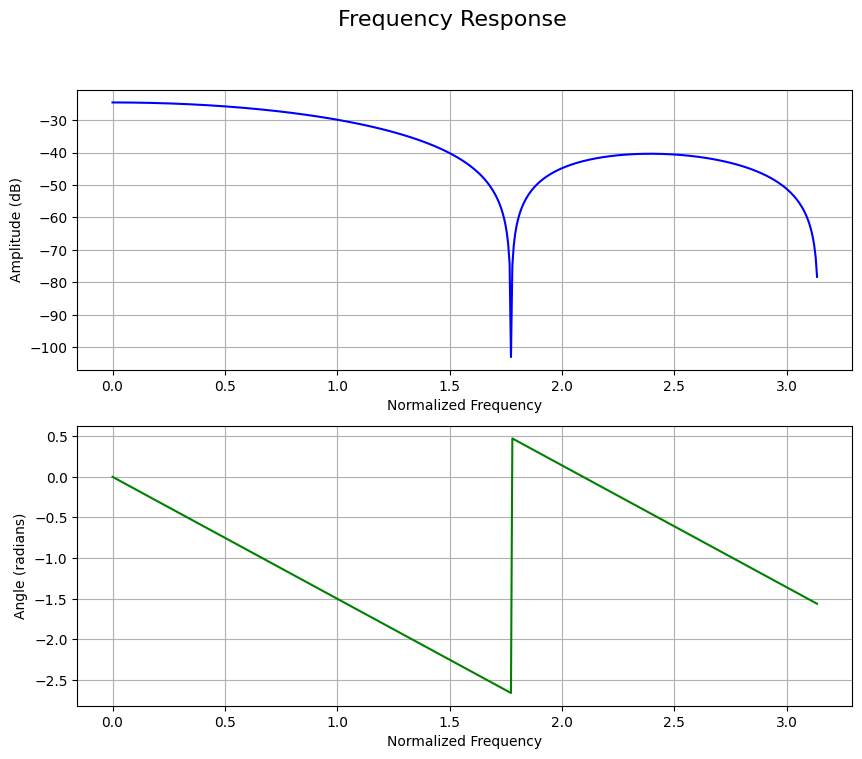

In [32]:
from scipy.signal import freqz
import numpy as np

w, h_response  = freqz(c)

fig=plt.figure(figsize=(10,8))
fig.suptitle('Frequency Response', fontsize=16)
plt.subplot(2,1,1)
plt.plot(w, 20 * np.log10(abs(h_response)), 'b')
plt.ylabel('Amplitude (dB)')
plt.xlabel('Normalized Frequency')
plt.grid()
plt.subplot(2,1,2)
angles = np.unwrap(np.angle(h_response))
plt.plot(w, angles, 'g')
plt.ylabel('Angle (radians)')
plt.xlabel('Normalized Frequency')
plt.grid()

This is the filter we obtain from the c coefficients if we don't replace the delays by allpasses. Here we can see that in the warped domain, we obtain a reasonable low pass filter.

In the passband from 0 to somewhat above 1.6 it has a drop of about 10 dB, and in the stopband we obtain about - 30 dB attenuation, which is much more than before (it might still not be enough for practical purposes though).

Now we use the same c coefficients, but replace the Delays in the FIR filter with Allpass filters (in this way we go from
frequency response $H(z)$ to $ H_{warped}(z)=H(H_{ap}(a,z)^-1)$

<center>
    <img src='https://github.com/GuitarsAI/ADSP_Tutorials/blob/master/images/lecture10_allpass.jpg?raw=1' width="600">
</center>

In [33]:
# Warping Allpass filters:
#Numerrator:
B = [-a.conjugate(), 1]
#Denominator:
A = [1, -a]
# Impulse with 80 zeros:
Imp = np.zeros(80)
Imp[0] = 1
x = Imp;

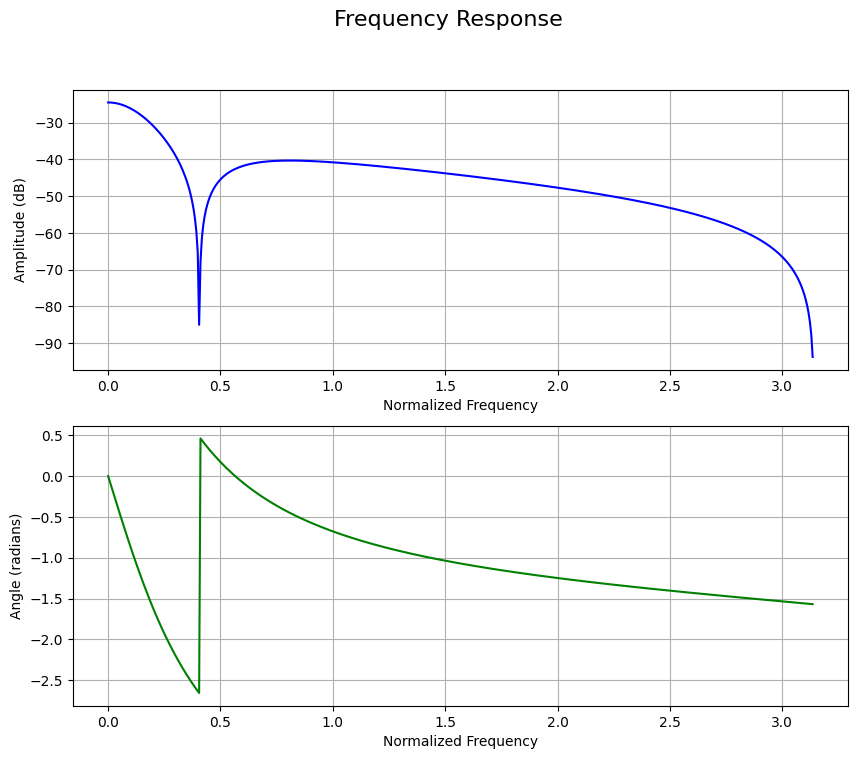

In [34]:
# Y1(z)=A(z), Y2(z)=A^2(z),...
# Warped delays:
y1 = sp.lfilter(B,A,x)
y2 = sp.lfilter(B,A,y1)
y3 = sp.lfilter(B,A,y2)

# Output of warped filter with impulse as input:
yout = c[0]*x+c[1]*y1+c[2]*y2+c[3]*y3

# frequency response:
from scipy.signal import freqz
import numpy as np
from matplotlib.ticker import FuncFormatter, MultipleLocator

w, h_response  = freqz(yout)
fig=plt.figure(figsize=(10,8))
fig.suptitle('Frequency Response', fontsize=16)
plt.subplot(2,1,1)
plt.plot(w, 20 * np.log10(abs(h_response)), 'b')
plt.ylabel('Amplitude (dB)')
plt.xlabel('Normalized Frequency')
plt.grid()
plt.subplot(2,1,2)
angles = np.unwrap(np.angle(h_response))
plt.plot(w, angles, 'g')
plt.ylabel('Angle (radians)')
plt.xlabel('Normalized Frequency')
plt.grid()

Here we can now see the frequency response of our final warped low pass filter.

We can see that again we have a drop of about 10 dB in the passband, now from 0 to 0.05pi, and a stopband attenuation of
about 30dB, which is somewhat reasonable.

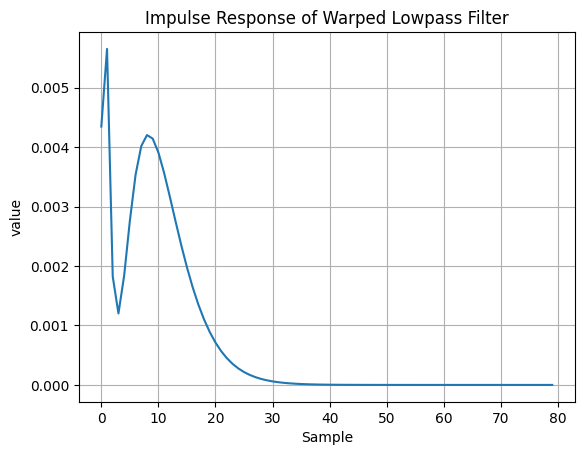

In [35]:
#Impulse response:
plt.figure()
plt.plot(yout);
plt.xlabel('Sample')
plt.ylabel('value')
plt.title('Impulse Response of Warped Lowpass Filter')
plt.grid()

This is the resulting impulse response of our warped filter.

What is most obvious is its length. Instead of just 4 samples, as our original unwarped design, it easily reaches 80 significant samples, and in principle is infinite in extend.

This is also what makes it a much better filter than the unwarped original design!

**References:**

    - [1] Julius O. Smith and Jonathan S. Abel,
    “Bark and ERB Bilinear Transforms,”
    IEEE Transactions on Speech and Audio Processing, vol. 7, no. 6,
    pp. 697 – 708, November 1999.
    - [2] S. Wabnik, G. Schuller, U. Kraemer, J. Hirschfeld:
    "Frequency Warping in Low Delay Audio Coding",
    IEEE International Conference on Acoustics,
    Speech, and Signal Processing, Philadelphia, PA, March 18–23, 2005

# Minimum Phase Filters

In [36]:
%%html
<iframe width="560" height="315" src="https://www.youtube.com/embed/pBhujbXISVw" frameborder="0" allow="accelerometer; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

Remember linear phase filters. Its phase function is linear:

$$\large
\phi(\Omega) = -\Omega \cdot d $$

with a group delay of constant d. The impulse responses of linear phase filters have the property of being (even) symmetric around some center.

**Example:**

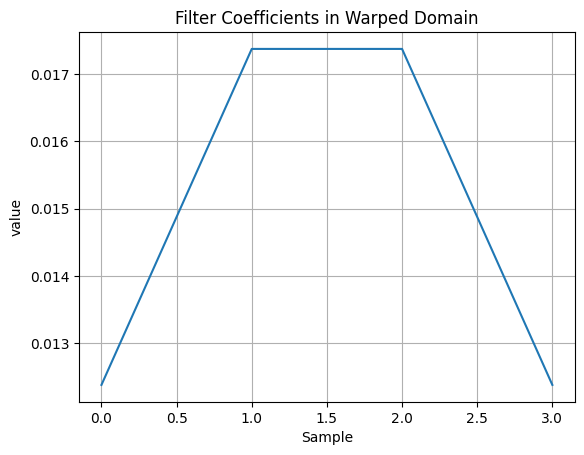

In [37]:
plt.figure()
plt.plot(c);
plt.xlabel('Sample')
plt.ylabel('value')
plt.title('Filter Coefficients in Warped Domain')
plt.grid()

Here we have a 4 sample impulse response, and starting at 0, we have a symmetry around d=1.5, hence we have a constant delay of this system of d=1.5 samples.

Another example for a linear phase filter is a piece of a sinc function.

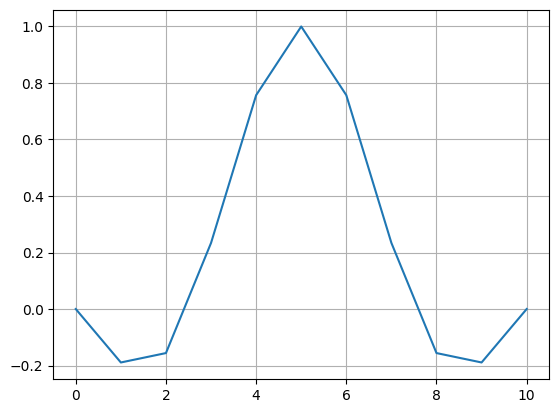

In [38]:
hsinc=np.sinc(np.linspace(-2,2,11))
plt.figure()
plt.plot(hsinc)
plt.grid()

This FIR filter has a constant delay factor of d=5.

The delay factor d is the center of the impulse response, and we can factor it out from the DTFT of the symmetric impulse response:

$$ \large
H \left( e^{j\Omega} \right) = \sum_{n=0}^{2d} h(n) \cdot \left( e^{-j\Omega n} \right)
$$

We factor out the center exponential,

$$ \large
H \left( e^{j\Omega} \right) =\left( e^{-j\Omega d} \right) \cdot \sum_{n=0}^{2d} h(n) \cdot \left( e^{-j\Omega (n-d)} \right)
$$

since $h(d-n)=h(d+n)$ we get:

$$ \large
H \left( e^{j\Omega} \right) =\left( e^{-j\Omega d} \right) \cdot \sum_{n=0}^{d} h(n) \cdot
\left( e^{-j\Omega (d-n)} + e^{j\Omega (d-n)} \right)
$$

$$\large
H \left( e^{j\Omega} \right) =\left( e^{-j\Omega d} \right) \cdot \sum_{n=0}^{d} h(n) \cdot
2 \cdot \cos{(\Omega(d-n))}$$

Hence the phase is

$$\large
angle \left(H \left( e^{j\Omega} \right) \right) = \phi (\Omega)=-d\cdot\Omega $$

Hence here we showed that any **symmetric** filter has a **linear phase**, and that the center sample corresponds to the signal delay.

Now we can plot its zeros in the complex plane of the z-transform:

In [39]:
def zplane(B,A):
    # Plot Poles and Zeros
    from  matplotlib import patches
    plt.figure(figsize=(10,8))
    ax = plt.subplot(111)
    r = 2.5; plt.axis('scaled'); plt.axis([-r, r, -r, r])
    #ticks = [-1, 1]; plt.xticks(ticks); plt.yticks(ticks)
    # Unit Circle
    uc = patches.Circle((0,0), radius=1, fill=False, color='black', ls='dashed')
    ax.add_patch(uc)
    ax.spines['left'].set_position('center')
    ax.spines['bottom'].set_position('center')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.xlabel('Re', horizontalalignment='right', x=1.0)
    plt.ylabel('Im',  y=1.0)
    plt.title('Complex z-Plane', loc='right')
    plt.grid()
    plt.plot(np.real(A),np.imag(A),'rx')
    plt.plot(np.real(B),np.imag(B),'bo')

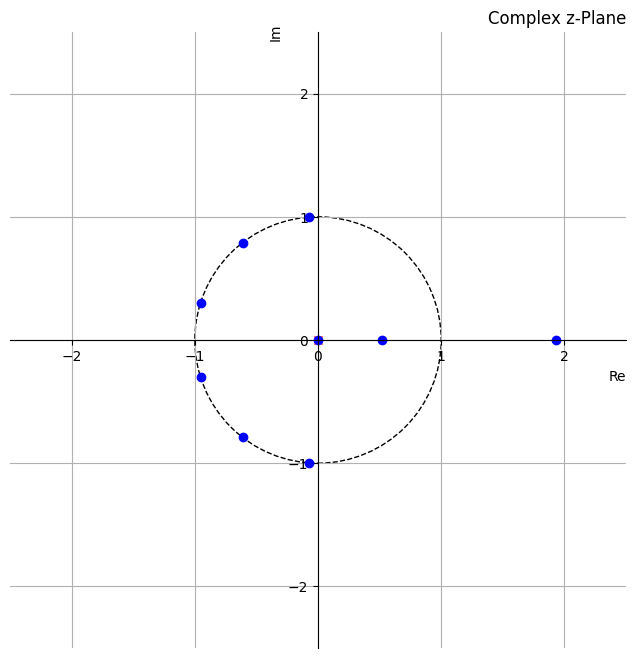

In [40]:
zplane(np.roots(hsinc), 0)

Observe the zeros near 1.9 and near 0.5, and on the unit circle.

Its zeros are computed with the command “roots”, and their magnitude with “abs”:

In [41]:
abs(np.roots(hsinc))

array([4.85372863e+15, 1.93092871e+00, 9.99999925e-01, 9.99999925e-01,
       1.00000011e+00, 1.00000011e+00, 9.99999953e-01, 9.99999953e-01,
       5.17885523e-01, 2.06057359e-16])

Here we can see that we have one zero at location 0, and one at infinity, 6 zeros are on the unit circle, one at distance 1.9309 from the origin, and one is at distance 5.1789e-01=1/1.9309.

Hence for those 2 zeros we have one zero inside the unit circle at distance r, and one outside the unit circle at distance 1/r.

Linear phase systems and filters have the property, that their **zeros are inside and outside the unit circle** in the z-domain.

For stability, only poles need to be inside the unit circle, not the zeros. But if we want to invert such a filter (for instance for equalization purposes), the zeros turn into poles, and the **zeros outside the unit circle** turn into poles outside the unit circle, making the **inverse filter unstable!**

To avoid the instability of the inverse filter, we define **minimum phase filters** such that their **inverse is also stable!**

This means, all their **zeros need to be inside the unit circle** in the z-domain.

We can write all linear filters as a concatenation of a minimum phase filter with an allpass filter,

$$\large
H(z) = H_{min}(z) \cdot H_{ap}(z) $$




In [42]:
%%html
<iframe width="560" height="315" src="https://www.youtube.com/embed/Uvv7lycNb50" frameborder="0" allow="accelerometer; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

This can be seen  from a (hypotetical) minimum phase system $H_{min}(z)$, which has all its zeros inside the unit circle.

Now we concatenate/multiply it with an allpass filter, such that its **poles coincide** with some of the **zeros** of the minimum phase filter inside the unit circle. These poles and zeros then **cancel**, and what is left is the zeros of the allpass filter outside the unit circle at a **reverse conjugate position** 1/a' , if “a” was the position of the original zero.
In this way, we can **„mirror out“ zeros from inside the unit circle to the outside.**

The **magnitude response does not change**, because we used an allpass (with magnitude 1) for mirroring out the zeros. As a
result we have a system with the **same** magnitude response, but now with **zeros outside** the unit circle.



Assume we would like to equalize or compensate a given transfer function, for instance from a recording. As we saw above, this transfer function can be written as the product

$$\large
H(z) = H_{min}(z) \cdot H_{ap}(z) $$

Only $H_{min}(z)$ has a stable inverse. Hence we design our compensation filter as:

$$\large
H_c(z)=\dfrac{1}{H_{min}(z)} $$

If we apply this compensation filter after our given transfer function, for instance from a recording, we obtain the overall system:

$$\large
G(z) = H(z) \cdot H_c(z) = H_{ap}(z) $$

This means the overall transfer function now is an allpass, with a constant magnitude response and only phase changes.
(see also A. Oppenheim, R. Schafer: “Discrete Time Signal Processing”, Prentice Hall)

In [43]:
%%html
<iframe width="560" height="315" src="https://www.youtube.com/embed/vtP8lTyrJm4" frameborder="0" allow="accelerometer; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

How can we obtain a minimum phase version from a given filter? We basically “mirror in” the zeros from outside the unit
circle. Take our above example of the piece of the sinc function filter.

In [44]:
%%html
<iframe width="560" height="315" src="https://www.youtube.com/embed/MqlapLy_lr8" frameborder="0" allow="accelerometer; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

In [45]:
rt=np.roots(hsinc)
rt

array([-4.85372863e+15+0.j        ,  1.93092871e+00+0.j        ,
       -9.53697827e-01+0.3007662j , -9.53697827e-01-0.3007662j ,
       -6.11572262e-01+0.79118872j, -6.11572262e-01-0.79118872j,
       -7.11596856e-02+0.99746489j, -7.11596856e-02-0.99746489j,
        5.17885523e-01+0.j        , -2.06057359e-16+0.j        ])

We see the zero at 1.93 which we need to mirror in (we neglect the zero at infinity, which comes from starting with a zero sample). To achieve this, we first take the z-domain polynomial of the impulse response, and cancel that zero by dividing by the polynomial with only that zero, $1-1.93\cdot z^−1$ .

Fortunately we have the function “deconvolve”, which is identical to polynomial division, to do this:

In [46]:
import scipy.signal as sp
[b, r] = sp.deconvolve(hsinc, [1,-rt[1]])
print('b:',b)
print('r',r)

b: [-3.89817183e-17+0.j -1.89206682e-01+0.j -5.21259495e-01+0.j
 -7.72642602e-01+0.j -7.35091052e-01+0.j -4.19408415e-01+0.j
 -5.30210197e-02+0.j  1.31492512e-01+0.j  9.79877853e-02+0.j
  7.45511113e-07+0.j]
r [ 0.00000000e+00+0.j  0.00000000e+00+0.j -5.55111512e-17+0.j
 -5.55111512e-17+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j
  0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j
  0.00000000e+00+0.j  1.43952881e-06+0.j]


Here, r is the remainder. In our case it is practically zero, which means we can indeed divide our polynomial without any remainder, which we expect since the zero we divide by was in the polynomial, so that we can always factor it out.

After that we can multiply the obtained polynomial b with the zero inside the unit circle, at position 1/1.93, by multiplying it with the polynomial with only that zero

$1−\dfrac{1}{1.93} \cdot z^{−1} :$

In [47]:
hsincmp = sp.convolve(b,[1,-1/rt[1].conjugate()])
hsincmp

array([-3.89817183e-17+0.j, -1.89206682e-01+0.j, -4.23272096e-01+0.j,
       -5.02689862e-01+0.j, -3.34950643e-01+0.j, -3.87154099e-02+0.j,
        1.64184521e-01+0.j,  1.58951330e-01+0.j,  2.98897187e-02+0.j,
       -5.07457087e-02+0.j, -3.86089404e-07+0.j])

This **hsincmp** is now our minimum phase version of our filter!

Now we can take a look at the impulse response:

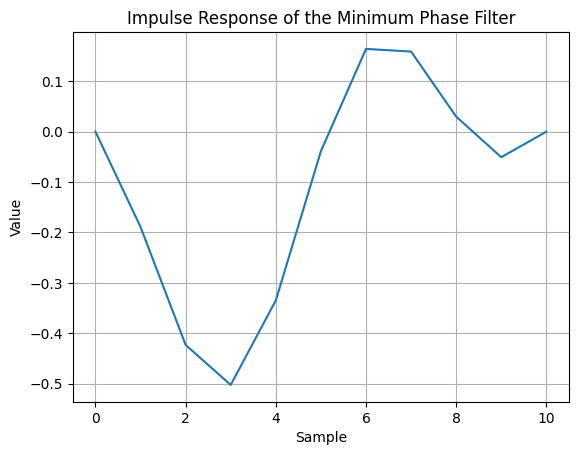

In [48]:
plt.figure()
plt.plot(np.real(hsincmp))
plt.xlabel('Sample')
plt.ylabel('Value')
plt.title('Impulse Response of the Minimum Phase Filter')
plt.grid()

Observe that our filter now became nonsymmetric, with the main peak at the beginning of the impulse response!

The resulting frequency response is obtained with:

In [49]:
%%html
<iframe width="560" height="315" src="https://www.youtube.com/embed/h0tJwGCwBOw" frameborder="0" allow="accelerometer; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

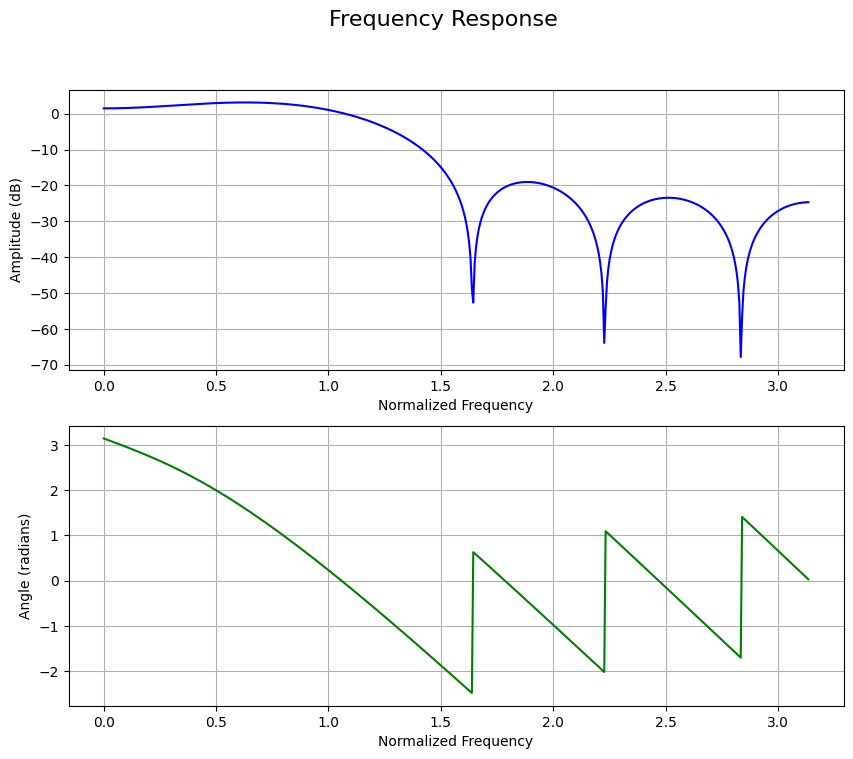

In [50]:
w, h_response  = freqz(hsincmp)
fig=plt.figure(figsize=(10,8))
fig.suptitle('Frequency Response', fontsize=16)
plt.subplot(2,1,1)
plt.plot(w, 20 * np.log10(abs(h_response)), 'b')
plt.ylabel('Amplitude (dB)')
plt.xlabel('Normalized Frequency')
plt.grid()
plt.subplot(2,1,2)
angles = np.angle(h_response)
plt.plot(w, np.unwrap(angles), 'g')
plt.ylabel('Angle (radians)')
plt.xlabel('Normalized Frequency')
plt.grid()

Now compare the above frequency response of our minimum phase filter with the linear phase version, with:

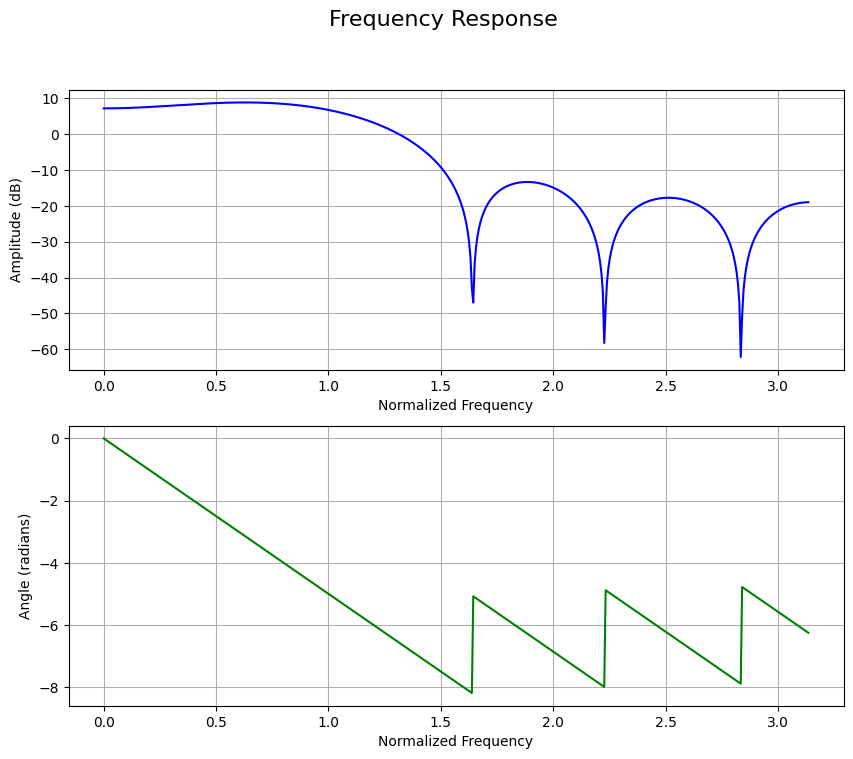

In [51]:
w, h_response  = freqz(hsinc)
fig=plt.figure(figsize=(10,8))
fig.suptitle('Frequency Response', fontsize=16)
plt.subplot(2,1,1)
plt.plot(w, 20 * np.log10(abs(h_response)), 'b')
plt.ylabel('Amplitude (dB)')
plt.xlabel('Normalized Frequency')
plt.grid()
plt.subplot(2,1,2)
angles = np.angle(h_response)
plt.plot(w, np.unwrap(angles), 'g')
plt.ylabel('Angle (radians)')
plt.xlabel('Normalized Frequency')
plt.grid()

Here we can see that the magnitude of the frequency plot is indeed identical between the linear phase and the minimum phase version (except for an offset of about 5 dB, which is not important because it is a constant gain factor).

But looking at the phase, we see that the minimum phase version has less phase lag.

Looking at normalized frequency 1.5, we see that the linear phase filter has a phase lag (or group delay) of about -7 Rad’s (using unwraping), whereas, the minimum phase filter has a **reduced phase** lag of about -5 Rad’s (from frequency zero to 1.5)!

If we take the derivative of the phase function to obtain the group delay, we will get correspondingly lower values, which means the minimum phase filter will have **less group delay** than the linear phase filter. In fact, it has **the lowest possible delay for the given magnitude response** of the filter.

So if you have a given magnitude filter design, and want to obtain the **lowest possible delay**, you have to take **minimum phase filters.**

Also observe the phase wrap around points. They are not always at $\pm\pi$, but in other cases where the magnitude has a zero crossing, where the phase is not well defined.

A convenient Scipy function to obtain a minimum phase filter with a similar (not exactly the same) magnitude frequency response of a linear phase filter is “scipy.signal.minimum_phase”.

In [52]:
help(sp.minimum_phase)

Help on function minimum_phase in module scipy.signal._fir_filter_design:

minimum_phase(h, method='homomorphic', n_fft=None)
    Convert a linear-phase FIR filter to minimum phase
    
    Parameters
    ----------
    h : array
        Linear-phase FIR filter coefficients.
    method : {'hilbert', 'homomorphic'}
        The method to use:
    
            'homomorphic' (default)
                This method [4]_ [5]_ works best with filters with an
                odd number of taps, and the resulting minimum phase filter
                will have a magnitude response that approximates the square
                root of the original filter's magnitude response.
    
            'hilbert'
                This method [1]_ is designed to be used with equiripple
                filters (e.g., from `remez`) with unity or zero gain
                regions.
    
    n_fft : int
        The number of points to use for the FFT. Should be at least a
        few times larger than the signal leng

As input it expects a filter with the **squared** desired frequency response, which we can obtain by convolving the linear phase filter coefficients with itself. In our example an approximate linear filter is obtained by:

In [53]:
import scipy.signal as sp
hsincsq=sp.convolve(hsinc,hsinc)
hmin=sp.minimum_phase(hsincsq)

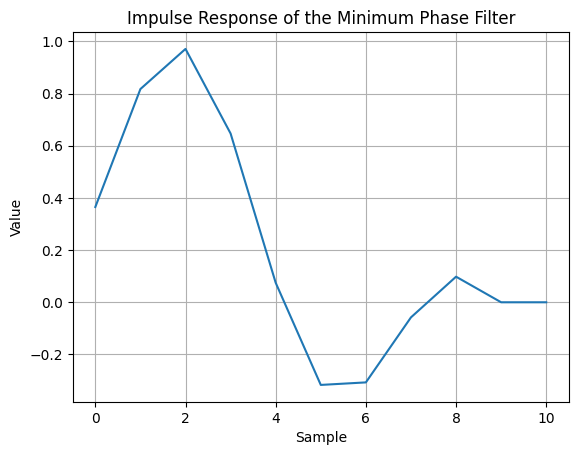

In [55]:
plt.figure()
plt.plot(np.real(hmin))
plt.xlabel('Sample')
plt.ylabel('Value')
plt.title('Impulse Response of the Minimum Phase Filter')
plt.grid()

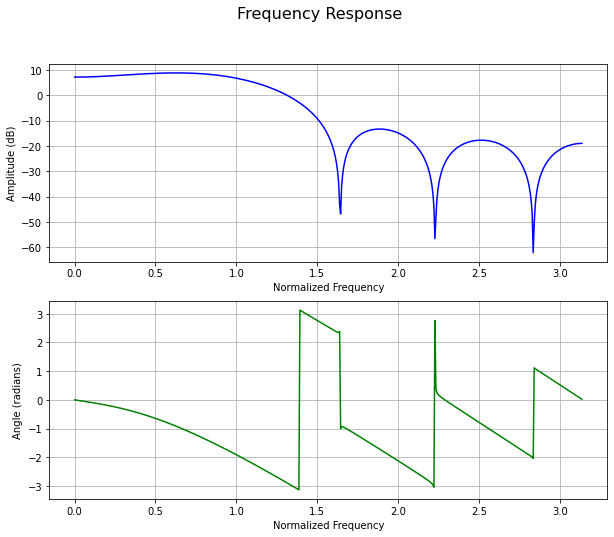

In [ ]:
w, h_response  = freqz(hmin)
fig=plt.figure(figsize=(10,8))
fig.suptitle('Frequency Response', fontsize=16)
plt.subplot(2,1,1)
plt.plot(w, 20 * np.log10(abs(h_response)), 'b')
plt.ylabel('Amplitude (dB)')
plt.xlabel('Normalized Frequency')
plt.grid()
plt.subplot(2,1,2)
angles = np.angle(h_response)
plt.plot(w, angles, 'g')
plt.ylabel('Angle (radians)')
plt.xlabel('Normalized Frequency')
plt.grid()

Observe that the magnitude again looks the same, but the phase looks different, because it starts at 0 instead of $\pi$ as before.

This is because the filter coefficients here have a switched sign. This is no problem because we can always change the sign by multiplying the filter or its output by -1.

Compare the coefficients by looking at them:


In [ ]:
print('hmin:', hmin)
print('hsincmp:',hsincmp)

hmin: [ 3.65083906e-01  8.17182307e-01  9.70913534e-01  6.46747848e-01
  7.48185839e-02 -3.16720511e-01 -3.07049417e-01 -5.78785657e-02
  9.80567656e-02  1.00599131e-06 -3.76131930e-07]
hsincmp: [-3.89817183e-17+0.j -1.89206682e-01+0.j -4.23272096e-01+0.j
 -5.02689862e-01+0.j -3.34950643e-01+0.j -3.87154099e-02+0.j
  1.64184521e-01+0.j  1.58951330e-01+0.j  2.98897187e-02+0.j
 -5.07457087e-02+0.j -3.86089404e-07+0.j]


We see: The coefficients are similar, but have indeed opposite signs.